In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn
import matplotlib.pyplot as plt
import matplotlib
import re

In [3]:
%matplotlib inline

In [4]:
import pandas as pd 
import numpy as np
from collections import defaultdict

In [5]:
from tqdm import tqdm
from tqdm import tqdm_notebook

In [6]:
from xgboost import XGBClassifier
import xgboost
from lightgbm import LGBMClassifier
import lightgbm

/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
from sklearn.metrics import roc_curve

In [78]:
from model import *
from transformers import *
from quality import *
from save_load import *

In [10]:
train = pd.read_csv("ml5/train.csv", sep=";")
test = pd.read_csv("ml5/test.csv", sep=";")
test["smoke"] = test["smoke"].apply(lambda x: np.nan if (x == "None")  else int(x))
test["alco"] = test["alco"].apply(lambda x: np.nan if (x == "None")  else int(x))
test["active"] = test["active"].apply(lambda x: np.nan if (x == "None")  else int(x))

In [11]:
def clone_nans(df, features):
    for feature in features:
        df1 = df[~df[feature].isnull()].copy()
        df2 = df[df[feature].isnull()].copy()
        df3 = df2.copy()
        df2[feature] = np.zeros(df2.shape[0])
        df3[feature] = np.ones(df3.shape[0])
        df = pd.concat([df1, df2, df3])
        
    return df
test2 = clone_nans(test, ["smoke", "alco", "active"])

In [12]:
ml = Model(train, test2, "cardio")

In [14]:
def ap_lo_func(x, axis):
    if x < 0:
        return -x
    if x == 0:
        return 40
    elif x <= 20:
        return 10 * x
    elif x <= 300:
        return x
    elif x <= 2000:
        return x * 1.0 / 10
    else:
        return x * 1.0 / 100

In [15]:
def ap_hi_func(x, axis):
    if x < 0:
        return - x
    elif x == 0:
        return 120
    elif x <= 20:
        return x * 10
    elif x <= 500:
        return x
    elif x <= 2000:
        return x * 1.0 / 10
    else:
        return x * 1.0 / 100

In [16]:
def days_to_year(x, axis):
    return x * 1.0 / 365

In [17]:
ml.remove_step("aplopr")
ml.add_step("aplopr", custom_transformer(ap_lo_func, ["ap_lo"], "aplopr"))

Trying to remove undefined step aplopr.


In [18]:
ml.remove_step("aplopr")
ml.add_step("aplopr", custom_transformer(ap_lo_func, ["ap_lo"], "aplopr"))
ml.remove_step("aphipr")
ml.add_step("aphipr", custom_transformer(ap_hi_func, ["ap_hi"], "aphipr"))
ml.remove_step("year")
ml.add_step("year", custom_transformer(days_to_year, ["age"], "year"))

ml.compute_step("aplopr")
ml.compute_step("aphipr")
ml.compute_step("year")

Trying to remove undefined step aphipr.


In [19]:
ml.remove_step("year")
ml.add_step("year", custom_transformer(days_to_year, ["age"], "year"))

Trying to remove undefined step year.


In [20]:
ml.compute_step("aplopr")

In [21]:
ml.compute_step("aphipr")

In [22]:
ml.compute_step("year")

In [23]:
ml.remove_step("onehot")
ml.add_step("onehot", onehot_transformer(["cholesterol", "gluc"], "onehot"))

Trying to remove undefined step onehot.


In [24]:
ml.compute_step("onehot")

In [25]:
ml.remove_step("log")
ml.add_step("log", logarithmic_transformer(["year", "height", "weight", "aphipr", "aplopr"], 0, "log"), prerequisites = ["year", "aphipr", "aplopr"])

Trying to remove undefined step log.


In [26]:
ml.compute_step("log")

In [27]:
ml.train.columns

Index([u'id', u'age', u'gender', u'height', u'weight', u'ap_hi', u'ap_lo',
       u'cholesterol', u'gluc', u'smoke', u'alco', u'active', u'cardio',
       u'aplopr', u'aphipr', u'year', u'cholesterol_0', u'cholesterol_1',
       u'cholesterol_2', u'gluc_3', u'gluc_4', u'gluc_5', u'log_aplopr',
       u'log_height', u'log_weight', u'log_aphipr', u'log_year'],
      dtype='object')

In [124]:
fl_n1 = ["year", "height", "weight", "aphipr", "aplopr", "log_aplopr", "log_height", "log_weight", "log_aphipr", "log_year"]
fl_c1 = ["gender", "cholesterol_0", "cholesterol_1", "cholesterol_2", "gluc_3", "gluc_4", "gluc_5", "alco", "smoke", "active"]

In [30]:
ml.remove_step("mulf1")
ml.add_step("mulf1", multiplication_transformer(fl_n1, [-2, -1, 2], 1, "mulf1"), prerequisites = ["year", "aphipr", "aplopr"])

Trying to remove undefined step mulf1.


In [31]:
ml.remove_step("mulf2")
ml.add_step("mulf2", multiplication_transformer(fl_n1, [-2, -1, 1, 2], 2, "mulf2"), prerequisites = ["year", "aphipr", "aplopr"])

Trying to remove undefined step mulf2.


In [35]:
ml.remove_step("mulf3")
ml.add_step("mulf3", multiplication_transformer(fl_n1, [-1, 1], 3, "mulf3"), prerequisites = ["year", "aphipr", "aplopr"])

Trying to remove undefined step mulf3.


In [33]:
ml.compute_step("mulf1")

In [34]:
ml.compute_step("mulf2")

In [36]:
ml.compute_step("mulf3")

In [125]:
fl1 = fl_n1 + fl_c1 + ml.get_step_columns(["mulf1", "mulf2", "mulf3"])
fl2 = fl_n1 + fl_c1 + ml.get_step_columns(["mulf1", "mulf2"])

In [126]:
print len(fl1)
print len(fl2)

1730
770


In [ ]:
ml.remove_step("scale1")
ml.add_step("scale1", scaling_transformer(fl2, "scale1"), prerequisites = ["mulf1", "mulf2", "mulf3"])

In [ ]:
ml.compute_step("scale1")

In [47]:
c_f = ['cholesterol_0', 'cholesterol_1', 'cholesterol_2', 'gluc_3', 'gluc_4', 'gluc_5', "gender", "alco", "smoke", "active"]
n_f = ["year", "height", "weight", "aphipr", "aplopr"]

In [54]:
lrclf_params_1 = {"C": 0.2, "n_jobs" : -1, "penalty": "l1"}

In [55]:
ml.remove_step("lr_s1")
ml.add_step("lr_s1", logreg_stacking(c_f+n_f, "cardio", lrclf_params_1, 10, "lr_s1"), prerequisites = ["scale1"])

In [56]:
ml.compute_step("lr_s1")

In [57]:
measure_logloss(ml, "train", "cardio", "lr_s1")

0.55922094681926393

In [129]:
ml.remove_step("scale2")
ml.add_step("scale2", scaling_transformer(fl1, "scale2"), prerequisites = ["mulf1", "mulf2", "mulf3"])

In [132]:
ml.compute_step("scale2")

In [69]:
ml.remove_step("lr_s2")
ml.add_step("lr_s2", logreg_stacking(ml.get_step_columns("scale2"), "cardio", lrclf_params_1, 10, "lr_s2"), prerequisites = ["scale2"])

In [70]:
ml.compute_step("lr_s2")

In [71]:
measure_logloss(ml, "train", "cardio", "lr_s2")

0.55191054909007498

In [ ]:
#xgbclf_params = {"objective":"binary:logistic", "max_depth":5, "learning_rate":0.01,
#                 "n_estimators": 500, "nthread":8, "base_score":0.5, "seed":47, "missing":None}
#ml.remove_step("xgb_s1")
#ml.add_step("xgb_s1", xgb_stacking(ml.get_step_columns("scale1"), "cardio", xgbclf_params, 5, "xgb_s1"), prerequisites = ["scale1"])
#ml.compute_step("xgb_s1")
#measure_logloss(ml, "train", "cardio", "xgb_s1")

In [133]:
lgbmclf_params = {"objective":"binary", "max_depth":6, "learning_rate":0.01,
                 "n_estimators": 500, "nthread":8, "seed":47}
ml.remove_step("lgbm_s1")
ml.add_step("lgbm_s1", lgbm_stacking(ml.get_step_columns("scale2"), "cardio", lgbmclf_params, 10, "lgbm_s1"), prerequisites = ["scale1"])

In [134]:
ml.compute_step("lgbm_s1")

[1]	training's binary_logloss: 0.69038	valid_1's binary_logloss: 0.690405
[2]	training's binary_logloss: 0.687669	valid_1's binary_logloss: 0.687711
[3]	training's binary_logloss: 0.685011	valid_1's binary_logloss: 0.685063
[4]	training's binary_logloss: 0.682404	valid_1's binary_logloss: 0.68247
[5]	training's binary_logloss: 0.679845	valid_1's binary_logloss: 0.679935
[6]	training's binary_logloss: 0.677341	valid_1's binary_logloss: 0.677437
[7]	training's binary_logloss: 0.674882	valid_1's binary_logloss: 0.674997
[8]	training's binary_logloss: 0.672473	valid_1's binary_logloss: 0.672602
[9]	training's binary_logloss: 0.670111	valid_1's binary_logloss: 0.670248
[10]	training's binary_logloss: 0.667784	valid_1's binary_logloss: 0.667943
[11]	training's binary_logloss: 0.665508	valid_1's binary_logloss: 0.665689
[12]	training's binary_logloss: 0.66327	valid_1's binary_logloss: 0.663477
[13]	training's binary_logloss: 0.661071	valid_1's binary_logloss: 0.661279
[14]	training's binary_l

[110]	training's binary_logloss: 0.559281	valid_1's binary_logloss: 0.561417
[111]	training's binary_logloss: 0.558857	valid_1's binary_logloss: 0.561037
[112]	training's binary_logloss: 0.558442	valid_1's binary_logloss: 0.560653
[113]	training's binary_logloss: 0.558029	valid_1's binary_logloss: 0.560289
[114]	training's binary_logloss: 0.55762	valid_1's binary_logloss: 0.559904
[115]	training's binary_logloss: 0.557215	valid_1's binary_logloss: 0.559527
[116]	training's binary_logloss: 0.556824	valid_1's binary_logloss: 0.559177
[117]	training's binary_logloss: 0.556438	valid_1's binary_logloss: 0.558829
[118]	training's binary_logloss: 0.556053	valid_1's binary_logloss: 0.558471
[119]	training's binary_logloss: 0.55568	valid_1's binary_logloss: 0.558133
[120]	training's binary_logloss: 0.555311	valid_1's binary_logloss: 0.5578
[121]	training's binary_logloss: 0.554943	valid_1's binary_logloss: 0.557453
[122]	training's binary_logloss: 0.554586	valid_1's binary_logloss: 0.557146
[12

[217]	training's binary_logloss: 0.535485	valid_1's binary_logloss: 0.541349
[218]	training's binary_logloss: 0.535377	valid_1's binary_logloss: 0.541276
[219]	training's binary_logloss: 0.535274	valid_1's binary_logloss: 0.541225
[220]	training's binary_logloss: 0.535167	valid_1's binary_logloss: 0.541161
[221]	training's binary_logloss: 0.535065	valid_1's binary_logloss: 0.5411
[222]	training's binary_logloss: 0.534964	valid_1's binary_logloss: 0.541043
[223]	training's binary_logloss: 0.534862	valid_1's binary_logloss: 0.540985
[224]	training's binary_logloss: 0.534759	valid_1's binary_logloss: 0.540933
[225]	training's binary_logloss: 0.534658	valid_1's binary_logloss: 0.540872
[226]	training's binary_logloss: 0.53456	valid_1's binary_logloss: 0.540824
[227]	training's binary_logloss: 0.534463	valid_1's binary_logloss: 0.54076
[228]	training's binary_logloss: 0.53437	valid_1's binary_logloss: 0.540713
[229]	training's binary_logloss: 0.534266	valid_1's binary_logloss: 0.540651
[230

[324]	training's binary_logloss: 0.52741	valid_1's binary_logloss: 0.538021
[325]	training's binary_logloss: 0.527348	valid_1's binary_logloss: 0.538009
[326]	training's binary_logloss: 0.527291	valid_1's binary_logloss: 0.537999
[327]	training's binary_logloss: 0.52723	valid_1's binary_logloss: 0.537984
[328]	training's binary_logloss: 0.527174	valid_1's binary_logloss: 0.537983
[329]	training's binary_logloss: 0.527117	valid_1's binary_logloss: 0.537974
[330]	training's binary_logloss: 0.527057	valid_1's binary_logloss: 0.53796
[331]	training's binary_logloss: 0.527002	valid_1's binary_logloss: 0.537946
[332]	training's binary_logloss: 0.526948	valid_1's binary_logloss: 0.537947
[333]	training's binary_logloss: 0.526892	valid_1's binary_logloss: 0.537931
[334]	training's binary_logloss: 0.526832	valid_1's binary_logloss: 0.537916
[335]	training's binary_logloss: 0.526779	valid_1's binary_logloss: 0.537915
[336]	training's binary_logloss: 0.526727	valid_1's binary_logloss: 0.537901
[3

[431]	training's binary_logloss: 0.522131	valid_1's binary_logloss: 0.537704
[432]	training's binary_logloss: 0.522088	valid_1's binary_logloss: 0.53772
[433]	training's binary_logloss: 0.522044	valid_1's binary_logloss: 0.53772
[434]	training's binary_logloss: 0.521999	valid_1's binary_logloss: 0.537721
[435]	training's binary_logloss: 0.521951	valid_1's binary_logloss: 0.537726
[436]	training's binary_logloss: 0.521909	valid_1's binary_logloss: 0.537728
[437]	training's binary_logloss: 0.521861	valid_1's binary_logloss: 0.537727
[438]	training's binary_logloss: 0.521819	valid_1's binary_logloss: 0.537724
[439]	training's binary_logloss: 0.521776	valid_1's binary_logloss: 0.537726
[440]	training's binary_logloss: 0.52173	valid_1's binary_logloss: 0.537722
[441]	training's binary_logloss: 0.521688	valid_1's binary_logloss: 0.537726
[442]	training's binary_logloss: 0.52165	valid_1's binary_logloss: 0.537727
[443]	training's binary_logloss: 0.521609	valid_1's binary_logloss: 0.537725
[44

[39]	training's binary_logloss: 0.615384	valid_1's binary_logloss: 0.619365
[40]	training's binary_logloss: 0.614028	valid_1's binary_logloss: 0.618095
[41]	training's binary_logloss: 0.612693	valid_1's binary_logloss: 0.616842
[42]	training's binary_logloss: 0.611383	valid_1's binary_logloss: 0.615611
[43]	training's binary_logloss: 0.610092	valid_1's binary_logloss: 0.614408
[44]	training's binary_logloss: 0.608825	valid_1's binary_logloss: 0.613217
[45]	training's binary_logloss: 0.607583	valid_1's binary_logloss: 0.612045
[46]	training's binary_logloss: 0.606357	valid_1's binary_logloss: 0.610919
[47]	training's binary_logloss: 0.605155	valid_1's binary_logloss: 0.609791
[48]	training's binary_logloss: 0.603968	valid_1's binary_logloss: 0.608696
[49]	training's binary_logloss: 0.602806	valid_1's binary_logloss: 0.607612
[50]	training's binary_logloss: 0.601657	valid_1's binary_logloss: 0.606559
[51]	training's binary_logloss: 0.600529	valid_1's binary_logloss: 0.605524
[52]	trainin

[147]	training's binary_logloss: 0.545922	valid_1's binary_logloss: 0.557722
[148]	training's binary_logloss: 0.545672	valid_1's binary_logloss: 0.557541
[149]	training's binary_logloss: 0.545424	valid_1's binary_logloss: 0.557344
[150]	training's binary_logloss: 0.545183	valid_1's binary_logloss: 0.557169
[151]	training's binary_logloss: 0.544946	valid_1's binary_logloss: 0.556993
[152]	training's binary_logloss: 0.544709	valid_1's binary_logloss: 0.556802
[153]	training's binary_logloss: 0.544478	valid_1's binary_logloss: 0.556641
[154]	training's binary_logloss: 0.54425	valid_1's binary_logloss: 0.556476
[155]	training's binary_logloss: 0.544024	valid_1's binary_logloss: 0.556306
[156]	training's binary_logloss: 0.543801	valid_1's binary_logloss: 0.556148
[157]	training's binary_logloss: 0.543582	valid_1's binary_logloss: 0.555972
[158]	training's binary_logloss: 0.543367	valid_1's binary_logloss: 0.555812
[159]	training's binary_logloss: 0.543153	valid_1's binary_logloss: 0.555657


[254]	training's binary_logloss: 0.530949	valid_1's binary_logloss: 0.548455
[255]	training's binary_logloss: 0.530873	valid_1's binary_logloss: 0.548431
[256]	training's binary_logloss: 0.530802	valid_1's binary_logloss: 0.548412
[257]	training's binary_logloss: 0.530721	valid_1's binary_logloss: 0.548367
[258]	training's binary_logloss: 0.530646	valid_1's binary_logloss: 0.548337
[259]	training's binary_logloss: 0.530574	valid_1's binary_logloss: 0.548312
[260]	training's binary_logloss: 0.530493	valid_1's binary_logloss: 0.548282
[261]	training's binary_logloss: 0.530422	valid_1's binary_logloss: 0.548256
[262]	training's binary_logloss: 0.53035	valid_1's binary_logloss: 0.548227
[263]	training's binary_logloss: 0.530273	valid_1's binary_logloss: 0.548197
[264]	training's binary_logloss: 0.530194	valid_1's binary_logloss: 0.548158
[265]	training's binary_logloss: 0.53012	valid_1's binary_logloss: 0.548134
[266]	training's binary_logloss: 0.530047	valid_1's binary_logloss: 0.548098
[

[361]	training's binary_logloss: 0.524446	valid_1's binary_logloss: 0.546738
[362]	training's binary_logloss: 0.524396	valid_1's binary_logloss: 0.546727
[363]	training's binary_logloss: 0.524348	valid_1's binary_logloss: 0.546714
[364]	training's binary_logloss: 0.524299	valid_1's binary_logloss: 0.546717
[365]	training's binary_logloss: 0.524246	valid_1's binary_logloss: 0.546708
[366]	training's binary_logloss: 0.524196	valid_1's binary_logloss: 0.5467
[367]	training's binary_logloss: 0.524144	valid_1's binary_logloss: 0.546697
[368]	training's binary_logloss: 0.524096	valid_1's binary_logloss: 0.546693
[369]	training's binary_logloss: 0.524048	valid_1's binary_logloss: 0.546683
[370]	training's binary_logloss: 0.523998	valid_1's binary_logloss: 0.546681
[371]	training's binary_logloss: 0.523955	valid_1's binary_logloss: 0.54667
[372]	training's binary_logloss: 0.523911	valid_1's binary_logloss: 0.546678
[373]	training's binary_logloss: 0.523862	valid_1's binary_logloss: 0.546687
[3

[468]	training's binary_logloss: 0.51978	valid_1's binary_logloss: 0.546853
[469]	training's binary_logloss: 0.519738	valid_1's binary_logloss: 0.546843
[470]	training's binary_logloss: 0.519696	valid_1's binary_logloss: 0.54684
[471]	training's binary_logloss: 0.519659	valid_1's binary_logloss: 0.546843
[472]	training's binary_logloss: 0.519636	valid_1's binary_logloss: 0.546842
[473]	training's binary_logloss: 0.519603	valid_1's binary_logloss: 0.546832
[474]	training's binary_logloss: 0.519564	valid_1's binary_logloss: 0.546824
[475]	training's binary_logloss: 0.519521	valid_1's binary_logloss: 0.546824
[476]	training's binary_logloss: 0.519479	valid_1's binary_logloss: 0.546844
[477]	training's binary_logloss: 0.519434	valid_1's binary_logloss: 0.546858
[478]	training's binary_logloss: 0.519397	valid_1's binary_logloss: 0.546862
[479]	training's binary_logloss: 0.519359	valid_1's binary_logloss: 0.546859
[480]	training's binary_logloss: 0.519333	valid_1's binary_logloss: 0.546863
[

[76]	training's binary_logloss: 0.578672	valid_1's binary_logloss: 0.579953
[77]	training's binary_logloss: 0.577934	valid_1's binary_logloss: 0.579246
[78]	training's binary_logloss: 0.577213	valid_1's binary_logloss: 0.578552
[79]	training's binary_logloss: 0.576501	valid_1's binary_logloss: 0.577874
[80]	training's binary_logloss: 0.575807	valid_1's binary_logloss: 0.577186
[81]	training's binary_logloss: 0.575119	valid_1's binary_logloss: 0.576533
[82]	training's binary_logloss: 0.574448	valid_1's binary_logloss: 0.575869
[83]	training's binary_logloss: 0.57379	valid_1's binary_logloss: 0.575227
[84]	training's binary_logloss: 0.57314	valid_1's binary_logloss: 0.574601
[85]	training's binary_logloss: 0.572501	valid_1's binary_logloss: 0.573983
[86]	training's binary_logloss: 0.571873	valid_1's binary_logloss: 0.57337
[87]	training's binary_logloss: 0.571254	valid_1's binary_logloss: 0.572761
[88]	training's binary_logloss: 0.570641	valid_1's binary_logloss: 0.572164
[89]	training's

[183]	training's binary_logloss: 0.540092	valid_1's binary_logloss: 0.544094
[184]	training's binary_logloss: 0.53994	valid_1's binary_logloss: 0.543967
[185]	training's binary_logloss: 0.539788	valid_1's binary_logloss: 0.54386
[186]	training's binary_logloss: 0.539634	valid_1's binary_logloss: 0.543747
[187]	training's binary_logloss: 0.539485	valid_1's binary_logloss: 0.543639
[188]	training's binary_logloss: 0.539343	valid_1's binary_logloss: 0.543513
[189]	training's binary_logloss: 0.539194	valid_1's binary_logloss: 0.543389
[190]	training's binary_logloss: 0.539052	valid_1's binary_logloss: 0.543294
[191]	training's binary_logloss: 0.538912	valid_1's binary_logloss: 0.543185
[192]	training's binary_logloss: 0.538772	valid_1's binary_logloss: 0.54309
[193]	training's binary_logloss: 0.538635	valid_1's binary_logloss: 0.543002
[194]	training's binary_logloss: 0.538493	valid_1's binary_logloss: 0.542893
[195]	training's binary_logloss: 0.53836	valid_1's binary_logloss: 0.542789
[19

[290]	training's binary_logloss: 0.529733	valid_1's binary_logloss: 0.537971
[291]	training's binary_logloss: 0.52967	valid_1's binary_logloss: 0.537931
[292]	training's binary_logloss: 0.529603	valid_1's binary_logloss: 0.537908
[293]	training's binary_logloss: 0.529549	valid_1's binary_logloss: 0.537895
[294]	training's binary_logloss: 0.529481	valid_1's binary_logloss: 0.537875
[295]	training's binary_logloss: 0.52942	valid_1's binary_logloss: 0.537859
[296]	training's binary_logloss: 0.529355	valid_1's binary_logloss: 0.537829
[297]	training's binary_logloss: 0.529289	valid_1's binary_logloss: 0.537815
[298]	training's binary_logloss: 0.529231	valid_1's binary_logloss: 0.53781
[299]	training's binary_logloss: 0.529169	valid_1's binary_logloss: 0.537775
[300]	training's binary_logloss: 0.529105	valid_1's binary_logloss: 0.537744
[301]	training's binary_logloss: 0.529045	valid_1's binary_logloss: 0.537708
[302]	training's binary_logloss: 0.528984	valid_1's binary_logloss: 0.537687
[3

[397]	training's binary_logloss: 0.524041	valid_1's binary_logloss: 0.536734
[398]	training's binary_logloss: 0.523998	valid_1's binary_logloss: 0.53673
[399]	training's binary_logloss: 0.52396	valid_1's binary_logloss: 0.536742
[400]	training's binary_logloss: 0.52391	valid_1's binary_logloss: 0.536739
[401]	training's binary_logloss: 0.523872	valid_1's binary_logloss: 0.536743
[402]	training's binary_logloss: 0.523822	valid_1's binary_logloss: 0.536742
[403]	training's binary_logloss: 0.523781	valid_1's binary_logloss: 0.536739
[404]	training's binary_logloss: 0.523743	valid_1's binary_logloss: 0.536732
[405]	training's binary_logloss: 0.5237	valid_1's binary_logloss: 0.53673
[406]	training's binary_logloss: 0.523652	valid_1's binary_logloss: 0.536727
[407]	training's binary_logloss: 0.523614	valid_1's binary_logloss: 0.536726
[408]	training's binary_logloss: 0.523566	valid_1's binary_logloss: 0.536727
[409]	training's binary_logloss: 0.523524	valid_1's binary_logloss: 0.536721
[410]

[4]	training's binary_logloss: 0.68239	valid_1's binary_logloss: 0.682553
[5]	training's binary_logloss: 0.679823	valid_1's binary_logloss: 0.680018
[6]	training's binary_logloss: 0.677311	valid_1's binary_logloss: 0.677541
[7]	training's binary_logloss: 0.674843	valid_1's binary_logloss: 0.675113
[8]	training's binary_logloss: 0.672426	valid_1's binary_logloss: 0.672731
[9]	training's binary_logloss: 0.67005	valid_1's binary_logloss: 0.670392
[10]	training's binary_logloss: 0.66772	valid_1's binary_logloss: 0.668101
[11]	training's binary_logloss: 0.665433	valid_1's binary_logloss: 0.665851
[12]	training's binary_logloss: 0.663196	valid_1's binary_logloss: 0.663664
[13]	training's binary_logloss: 0.660996	valid_1's binary_logloss: 0.661491
[14]	training's binary_logloss: 0.658838	valid_1's binary_logloss: 0.659372
[15]	training's binary_logloss: 0.656731	valid_1's binary_logloss: 0.657283
[16]	training's binary_logloss: 0.654651	valid_1's binary_logloss: 0.655246
[17]	training's binar

[113]	training's binary_logloss: 0.557805	valid_1's binary_logloss: 0.561471
[114]	training's binary_logloss: 0.557398	valid_1's binary_logloss: 0.561094
[115]	training's binary_logloss: 0.556998	valid_1's binary_logloss: 0.560742
[116]	training's binary_logloss: 0.5566	valid_1's binary_logloss: 0.560379
[117]	training's binary_logloss: 0.556213	valid_1's binary_logloss: 0.56005
[118]	training's binary_logloss: 0.555832	valid_1's binary_logloss: 0.559711
[119]	training's binary_logloss: 0.555455	valid_1's binary_logloss: 0.559353
[120]	training's binary_logloss: 0.555087	valid_1's binary_logloss: 0.55903
[121]	training's binary_logloss: 0.554714	valid_1's binary_logloss: 0.558713
[122]	training's binary_logloss: 0.554353	valid_1's binary_logloss: 0.558371
[123]	training's binary_logloss: 0.553993	valid_1's binary_logloss: 0.55807
[124]	training's binary_logloss: 0.553641	valid_1's binary_logloss: 0.557764
[125]	training's binary_logloss: 0.553295	valid_1's binary_logloss: 0.557455
[126

[220]	training's binary_logloss: 0.534874	valid_1's binary_logloss: 0.542746
[221]	training's binary_logloss: 0.534769	valid_1's binary_logloss: 0.542689
[222]	training's binary_logloss: 0.534663	valid_1's binary_logloss: 0.542631
[223]	training's binary_logloss: 0.534561	valid_1's binary_logloss: 0.542574
[224]	training's binary_logloss: 0.534463	valid_1's binary_logloss: 0.542508
[225]	training's binary_logloss: 0.534365	valid_1's binary_logloss: 0.542448
[226]	training's binary_logloss: 0.534265	valid_1's binary_logloss: 0.5424
[227]	training's binary_logloss: 0.534168	valid_1's binary_logloss: 0.542348
[228]	training's binary_logloss: 0.534068	valid_1's binary_logloss: 0.542305
[229]	training's binary_logloss: 0.533972	valid_1's binary_logloss: 0.542255
[230]	training's binary_logloss: 0.533877	valid_1's binary_logloss: 0.54219
[231]	training's binary_logloss: 0.533784	valid_1's binary_logloss: 0.542146
[232]	training's binary_logloss: 0.533685	valid_1's binary_logloss: 0.542079
[2

[327]	training's binary_logloss: 0.527063	valid_1's binary_logloss: 0.540064
[328]	training's binary_logloss: 0.527006	valid_1's binary_logloss: 0.540059
[329]	training's binary_logloss: 0.526945	valid_1's binary_logloss: 0.540047
[330]	training's binary_logloss: 0.526892	valid_1's binary_logloss: 0.54004
[331]	training's binary_logloss: 0.526836	valid_1's binary_logloss: 0.540043
[332]	training's binary_logloss: 0.526782	valid_1's binary_logloss: 0.540034
[333]	training's binary_logloss: 0.526724	valid_1's binary_logloss: 0.540036
[334]	training's binary_logloss: 0.526667	valid_1's binary_logloss: 0.54002
[335]	training's binary_logloss: 0.526612	valid_1's binary_logloss: 0.54002
[336]	training's binary_logloss: 0.526558	valid_1's binary_logloss: 0.540017
[337]	training's binary_logloss: 0.526499	valid_1's binary_logloss: 0.539992
[338]	training's binary_logloss: 0.526446	valid_1's binary_logloss: 0.539996
[339]	training's binary_logloss: 0.526392	valid_1's binary_logloss: 0.539995
[3

[434]	training's binary_logloss: 0.521833	valid_1's binary_logloss: 0.539793
[435]	training's binary_logloss: 0.521789	valid_1's binary_logloss: 0.539782
[436]	training's binary_logloss: 0.521739	valid_1's binary_logloss: 0.539789
[437]	training's binary_logloss: 0.521696	valid_1's binary_logloss: 0.539787
[438]	training's binary_logloss: 0.521654	valid_1's binary_logloss: 0.53979
[439]	training's binary_logloss: 0.521614	valid_1's binary_logloss: 0.539788
[440]	training's binary_logloss: 0.521568	valid_1's binary_logloss: 0.539801
[441]	training's binary_logloss: 0.521529	valid_1's binary_logloss: 0.539814
[442]	training's binary_logloss: 0.521483	valid_1's binary_logloss: 0.539815
[443]	training's binary_logloss: 0.521441	valid_1's binary_logloss: 0.539817
[444]	training's binary_logloss: 0.521397	valid_1's binary_logloss: 0.539813
[445]	training's binary_logloss: 0.521364	valid_1's binary_logloss: 0.539812
[446]	training's binary_logloss: 0.521324	valid_1's binary_logloss: 0.539821


[42]	training's binary_logloss: 0.611964	valid_1's binary_logloss: 0.611978
[43]	training's binary_logloss: 0.610683	valid_1's binary_logloss: 0.610708
[44]	training's binary_logloss: 0.609417	valid_1's binary_logloss: 0.609453
[45]	training's binary_logloss: 0.608176	valid_1's binary_logloss: 0.608226
[46]	training's binary_logloss: 0.606962	valid_1's binary_logloss: 0.607035
[47]	training's binary_logloss: 0.60576	valid_1's binary_logloss: 0.605847
[48]	training's binary_logloss: 0.604585	valid_1's binary_logloss: 0.604687
[49]	training's binary_logloss: 0.603431	valid_1's binary_logloss: 0.603562
[50]	training's binary_logloss: 0.602289	valid_1's binary_logloss: 0.602431
[51]	training's binary_logloss: 0.601172	valid_1's binary_logloss: 0.601336
[52]	training's binary_logloss: 0.600066	valid_1's binary_logloss: 0.600257
[53]	training's binary_logloss: 0.598989	valid_1's binary_logloss: 0.59921
[54]	training's binary_logloss: 0.597923	valid_1's binary_logloss: 0.598162
[55]	training'

[150]	training's binary_logloss: 0.546229	valid_1's binary_logloss: 0.548941
[151]	training's binary_logloss: 0.545995	valid_1's binary_logloss: 0.548749
[152]	training's binary_logloss: 0.545758	valid_1's binary_logloss: 0.54854
[153]	training's binary_logloss: 0.545533	valid_1's binary_logloss: 0.548359
[154]	training's binary_logloss: 0.545302	valid_1's binary_logloss: 0.54817
[155]	training's binary_logloss: 0.545079	valid_1's binary_logloss: 0.547973
[156]	training's binary_logloss: 0.544851	valid_1's binary_logloss: 0.547771
[157]	training's binary_logloss: 0.544631	valid_1's binary_logloss: 0.547578
[158]	training's binary_logloss: 0.54442	valid_1's binary_logloss: 0.547412
[159]	training's binary_logloss: 0.544204	valid_1's binary_logloss: 0.547243
[160]	training's binary_logloss: 0.543997	valid_1's binary_logloss: 0.547055
[161]	training's binary_logloss: 0.543788	valid_1's binary_logloss: 0.546888
[162]	training's binary_logloss: 0.543577	valid_1's binary_logloss: 0.546696
[1

[257]	training's binary_logloss: 0.531903	valid_1's binary_logloss: 0.538506
[258]	training's binary_logloss: 0.531827	valid_1's binary_logloss: 0.538466
[259]	training's binary_logloss: 0.53175	valid_1's binary_logloss: 0.538421
[260]	training's binary_logloss: 0.531673	valid_1's binary_logloss: 0.538395
[261]	training's binary_logloss: 0.531597	valid_1's binary_logloss: 0.538363
[262]	training's binary_logloss: 0.53152	valid_1's binary_logloss: 0.538321
[263]	training's binary_logloss: 0.531449	valid_1's binary_logloss: 0.538285
[264]	training's binary_logloss: 0.531374	valid_1's binary_logloss: 0.538239
[265]	training's binary_logloss: 0.531301	valid_1's binary_logloss: 0.538209
[266]	training's binary_logloss: 0.531225	valid_1's binary_logloss: 0.538164
[267]	training's binary_logloss: 0.531155	valid_1's binary_logloss: 0.538128
[268]	training's binary_logloss: 0.531085	valid_1's binary_logloss: 0.538093
[269]	training's binary_logloss: 0.531017	valid_1's binary_logloss: 0.538068
[

[364]	training's binary_logloss: 0.525686	valid_1's binary_logloss: 0.53656
[365]	training's binary_logloss: 0.525641	valid_1's binary_logloss: 0.536552
[366]	training's binary_logloss: 0.525588	valid_1's binary_logloss: 0.536528
[367]	training's binary_logloss: 0.525542	valid_1's binary_logloss: 0.536527
[368]	training's binary_logloss: 0.525489	valid_1's binary_logloss: 0.536505
[369]	training's binary_logloss: 0.525437	valid_1's binary_logloss: 0.536489
[370]	training's binary_logloss: 0.525391	valid_1's binary_logloss: 0.536501
[371]	training's binary_logloss: 0.525336	valid_1's binary_logloss: 0.536483
[372]	training's binary_logloss: 0.525291	valid_1's binary_logloss: 0.53649
[373]	training's binary_logloss: 0.525242	valid_1's binary_logloss: 0.536477
[374]	training's binary_logloss: 0.525185	valid_1's binary_logloss: 0.536466
[375]	training's binary_logloss: 0.525141	valid_1's binary_logloss: 0.53647
[376]	training's binary_logloss: 0.525087	valid_1's binary_logloss: 0.536463
[3

[472]	training's binary_logloss: 0.520832	valid_1's binary_logloss: 0.535955
[473]	training's binary_logloss: 0.520782	valid_1's binary_logloss: 0.535945
[474]	training's binary_logloss: 0.520748	valid_1's binary_logloss: 0.535937
[475]	training's binary_logloss: 0.520707	valid_1's binary_logloss: 0.535935
[476]	training's binary_logloss: 0.520657	valid_1's binary_logloss: 0.53594
[477]	training's binary_logloss: 0.520631	valid_1's binary_logloss: 0.535935
[478]	training's binary_logloss: 0.52059	valid_1's binary_logloss: 0.535945
[479]	training's binary_logloss: 0.520546	valid_1's binary_logloss: 0.535937
[480]	training's binary_logloss: 0.520521	valid_1's binary_logloss: 0.535931
[481]	training's binary_logloss: 0.520482	valid_1's binary_logloss: 0.535923
[482]	training's binary_logloss: 0.520439	valid_1's binary_logloss: 0.535926
[483]	training's binary_logloss: 0.520391	valid_1's binary_logloss: 0.535935
[484]	training's binary_logloss: 0.52036	valid_1's binary_logloss: 0.535955
[4

[80]	training's binary_logloss: 0.574696	valid_1's binary_logloss: 0.582785
[81]	training's binary_logloss: 0.574012	valid_1's binary_logloss: 0.582186
[82]	training's binary_logloss: 0.573335	valid_1's binary_logloss: 0.581596
[83]	training's binary_logloss: 0.572668	valid_1's binary_logloss: 0.581022
[84]	training's binary_logloss: 0.57201	valid_1's binary_logloss: 0.580457
[85]	training's binary_logloss: 0.571367	valid_1's binary_logloss: 0.579911
[86]	training's binary_logloss: 0.570731	valid_1's binary_logloss: 0.57937
[87]	training's binary_logloss: 0.570102	valid_1's binary_logloss: 0.578828
[88]	training's binary_logloss: 0.569489	valid_1's binary_logloss: 0.578308
[89]	training's binary_logloss: 0.568883	valid_1's binary_logloss: 0.577793
[90]	training's binary_logloss: 0.568292	valid_1's binary_logloss: 0.57728
[91]	training's binary_logloss: 0.567708	valid_1's binary_logloss: 0.576787
[92]	training's binary_logloss: 0.567129	valid_1's binary_logloss: 0.576289
[93]	training's

[187]	training's binary_logloss: 0.537999	valid_1's binary_logloss: 0.55344
[188]	training's binary_logloss: 0.537853	valid_1's binary_logloss: 0.55335
[189]	training's binary_logloss: 0.537711	valid_1's binary_logloss: 0.553262
[190]	training's binary_logloss: 0.537561	valid_1's binary_logloss: 0.553166
[191]	training's binary_logloss: 0.537418	valid_1's binary_logloss: 0.553072
[192]	training's binary_logloss: 0.537277	valid_1's binary_logloss: 0.552984
[193]	training's binary_logloss: 0.537132	valid_1's binary_logloss: 0.552894
[194]	training's binary_logloss: 0.536994	valid_1's binary_logloss: 0.552818
[195]	training's binary_logloss: 0.536852	valid_1's binary_logloss: 0.552741
[196]	training's binary_logloss: 0.536718	valid_1's binary_logloss: 0.552658
[197]	training's binary_logloss: 0.53658	valid_1's binary_logloss: 0.552576
[198]	training's binary_logloss: 0.536449	valid_1's binary_logloss: 0.552503
[199]	training's binary_logloss: 0.536316	valid_1's binary_logloss: 0.552412
[2

[294]	training's binary_logloss: 0.527944	valid_1's binary_logloss: 0.549127
[295]	training's binary_logloss: 0.52788	valid_1's binary_logloss: 0.549104
[296]	training's binary_logloss: 0.527816	valid_1's binary_logloss: 0.549084
[297]	training's binary_logloss: 0.527753	valid_1's binary_logloss: 0.549079
[298]	training's binary_logloss: 0.527692	valid_1's binary_logloss: 0.549059
[299]	training's binary_logloss: 0.527631	valid_1's binary_logloss: 0.549054
[300]	training's binary_logloss: 0.527571	valid_1's binary_logloss: 0.549033
[301]	training's binary_logloss: 0.52751	valid_1's binary_logloss: 0.54902
[302]	training's binary_logloss: 0.527455	valid_1's binary_logloss: 0.549006
[303]	training's binary_logloss: 0.527395	valid_1's binary_logloss: 0.548998
[304]	training's binary_logloss: 0.527338	valid_1's binary_logloss: 0.549001
[305]	training's binary_logloss: 0.527279	valid_1's binary_logloss: 0.548989
[306]	training's binary_logloss: 0.527218	valid_1's binary_logloss: 0.54898
[30

[401]	training's binary_logloss: 0.522321	valid_1's binary_logloss: 0.5484
[402]	training's binary_logloss: 0.522276	valid_1's binary_logloss: 0.54841
[403]	training's binary_logloss: 0.522228	valid_1's binary_logloss: 0.548406
[404]	training's binary_logloss: 0.522188	valid_1's binary_logloss: 0.548411
[405]	training's binary_logloss: 0.522142	valid_1's binary_logloss: 0.548406
[406]	training's binary_logloss: 0.522105	valid_1's binary_logloss: 0.54841
[407]	training's binary_logloss: 0.522063	valid_1's binary_logloss: 0.548413
[408]	training's binary_logloss: 0.522016	valid_1's binary_logloss: 0.548415
[409]	training's binary_logloss: 0.521965	valid_1's binary_logloss: 0.548393
[410]	training's binary_logloss: 0.521921	valid_1's binary_logloss: 0.548403
[411]	training's binary_logloss: 0.521871	valid_1's binary_logloss: 0.548385
[412]	training's binary_logloss: 0.521827	valid_1's binary_logloss: 0.548384
[413]	training's binary_logloss: 0.521789	valid_1's binary_logloss: 0.548387
[41

[8]	training's binary_logloss: 0.672488	valid_1's binary_logloss: 0.672691
[9]	training's binary_logloss: 0.670126	valid_1's binary_logloss: 0.670349
[10]	training's binary_logloss: 0.667809	valid_1's binary_logloss: 0.668041
[11]	training's binary_logloss: 0.665535	valid_1's binary_logloss: 0.665788
[12]	training's binary_logloss: 0.663302	valid_1's binary_logloss: 0.663554
[13]	training's binary_logloss: 0.66111	valid_1's binary_logloss: 0.661361
[14]	training's binary_logloss: 0.658961	valid_1's binary_logloss: 0.659214
[15]	training's binary_logloss: 0.656845	valid_1's binary_logloss: 0.65712
[16]	training's binary_logloss: 0.654767	valid_1's binary_logloss: 0.655026
[17]	training's binary_logloss: 0.652729	valid_1's binary_logloss: 0.652988
[18]	training's binary_logloss: 0.650729	valid_1's binary_logloss: 0.651009
[19]	training's binary_logloss: 0.648766	valid_1's binary_logloss: 0.649041
[20]	training's binary_logloss: 0.646847	valid_1's binary_logloss: 0.647139
[21]	training's 

[116]	training's binary_logloss: 0.557051	valid_1's binary_logloss: 0.558109
[117]	training's binary_logloss: 0.556666	valid_1's binary_logloss: 0.557729
[118]	training's binary_logloss: 0.556281	valid_1's binary_logloss: 0.557377
[119]	training's binary_logloss: 0.555905	valid_1's binary_logloss: 0.557019
[120]	training's binary_logloss: 0.555535	valid_1's binary_logloss: 0.556663
[121]	training's binary_logloss: 0.555169	valid_1's binary_logloss: 0.556331
[122]	training's binary_logloss: 0.55481	valid_1's binary_logloss: 0.555997
[123]	training's binary_logloss: 0.554456	valid_1's binary_logloss: 0.555676
[124]	training's binary_logloss: 0.554107	valid_1's binary_logloss: 0.555346
[125]	training's binary_logloss: 0.553762	valid_1's binary_logloss: 0.555007
[126]	training's binary_logloss: 0.553425	valid_1's binary_logloss: 0.554693
[127]	training's binary_logloss: 0.553092	valid_1's binary_logloss: 0.554389
[128]	training's binary_logloss: 0.552764	valid_1's binary_logloss: 0.554091


[223]	training's binary_logloss: 0.535227	valid_1's binary_logloss: 0.539157
[224]	training's binary_logloss: 0.535126	valid_1's binary_logloss: 0.539081
[225]	training's binary_logloss: 0.535022	valid_1's binary_logloss: 0.538996
[226]	training's binary_logloss: 0.534924	valid_1's binary_logloss: 0.538923
[227]	training's binary_logloss: 0.534823	valid_1's binary_logloss: 0.538848
[228]	training's binary_logloss: 0.534729	valid_1's binary_logloss: 0.538776
[229]	training's binary_logloss: 0.534631	valid_1's binary_logloss: 0.538709
[230]	training's binary_logloss: 0.534537	valid_1's binary_logloss: 0.538656
[231]	training's binary_logloss: 0.534444	valid_1's binary_logloss: 0.538581
[232]	training's binary_logloss: 0.534348	valid_1's binary_logloss: 0.538512
[233]	training's binary_logloss: 0.534255	valid_1's binary_logloss: 0.538455
[234]	training's binary_logloss: 0.534159	valid_1's binary_logloss: 0.538382
[235]	training's binary_logloss: 0.534067	valid_1's binary_logloss: 0.538323

[330]	training's binary_logloss: 0.527617	valid_1's binary_logloss: 0.535389
[331]	training's binary_logloss: 0.527567	valid_1's binary_logloss: 0.535362
[332]	training's binary_logloss: 0.527512	valid_1's binary_logloss: 0.535331
[333]	training's binary_logloss: 0.527463	valid_1's binary_logloss: 0.535304
[334]	training's binary_logloss: 0.527412	valid_1's binary_logloss: 0.535301
[335]	training's binary_logloss: 0.527361	valid_1's binary_logloss: 0.535285
[336]	training's binary_logloss: 0.527302	valid_1's binary_logloss: 0.535273
[337]	training's binary_logloss: 0.527252	valid_1's binary_logloss: 0.535265
[338]	training's binary_logloss: 0.527197	valid_1's binary_logloss: 0.535239
[339]	training's binary_logloss: 0.52715	valid_1's binary_logloss: 0.535214
[340]	training's binary_logloss: 0.527097	valid_1's binary_logloss: 0.535194
[341]	training's binary_logloss: 0.52705	valid_1's binary_logloss: 0.535184
[342]	training's binary_logloss: 0.527002	valid_1's binary_logloss: 0.535176
[

[437]	training's binary_logloss: 0.522706	valid_1's binary_logloss: 0.534255
[438]	training's binary_logloss: 0.522657	valid_1's binary_logloss: 0.53425
[439]	training's binary_logloss: 0.52261	valid_1's binary_logloss: 0.534234
[440]	training's binary_logloss: 0.522569	valid_1's binary_logloss: 0.534234
[441]	training's binary_logloss: 0.522529	valid_1's binary_logloss: 0.53423
[442]	training's binary_logloss: 0.522489	valid_1's binary_logloss: 0.534227
[443]	training's binary_logloss: 0.522466	valid_1's binary_logloss: 0.534219
[444]	training's binary_logloss: 0.522423	valid_1's binary_logloss: 0.534208
[445]	training's binary_logloss: 0.522394	valid_1's binary_logloss: 0.534207
[446]	training's binary_logloss: 0.522353	valid_1's binary_logloss: 0.534207
[447]	training's binary_logloss: 0.522308	valid_1's binary_logloss: 0.534197
[448]	training's binary_logloss: 0.522257	valid_1's binary_logloss: 0.534189
[449]	training's binary_logloss: 0.522217	valid_1's binary_logloss: 0.534179
[4

[45]	training's binary_logloss: 0.608198	valid_1's binary_logloss: 0.608687
[46]	training's binary_logloss: 0.606981	valid_1's binary_logloss: 0.607486
[47]	training's binary_logloss: 0.605787	valid_1's binary_logloss: 0.60631
[48]	training's binary_logloss: 0.604613	valid_1's binary_logloss: 0.60515
[49]	training's binary_logloss: 0.603453	valid_1's binary_logloss: 0.603994
[50]	training's binary_logloss: 0.602318	valid_1's binary_logloss: 0.602873
[51]	training's binary_logloss: 0.601204	valid_1's binary_logloss: 0.60177
[52]	training's binary_logloss: 0.600105	valid_1's binary_logloss: 0.600695
[53]	training's binary_logloss: 0.599025	valid_1's binary_logloss: 0.599643
[54]	training's binary_logloss: 0.597965	valid_1's binary_logloss: 0.598598
[55]	training's binary_logloss: 0.59692	valid_1's binary_logloss: 0.597583
[56]	training's binary_logloss: 0.595898	valid_1's binary_logloss: 0.596566
[57]	training's binary_logloss: 0.594889	valid_1's binary_logloss: 0.595582
[58]	training's 

[153]	training's binary_logloss: 0.545797	valid_1's binary_logloss: 0.548218
[154]	training's binary_logloss: 0.545571	valid_1's binary_logloss: 0.548003
[155]	training's binary_logloss: 0.545345	valid_1's binary_logloss: 0.547808
[156]	training's binary_logloss: 0.545127	valid_1's binary_logloss: 0.547615
[157]	training's binary_logloss: 0.544909	valid_1's binary_logloss: 0.547419
[158]	training's binary_logloss: 0.544694	valid_1's binary_logloss: 0.547232
[159]	training's binary_logloss: 0.544484	valid_1's binary_logloss: 0.547051
[160]	training's binary_logloss: 0.544274	valid_1's binary_logloss: 0.546868
[161]	training's binary_logloss: 0.544069	valid_1's binary_logloss: 0.546681
[162]	training's binary_logloss: 0.543861	valid_1's binary_logloss: 0.546508
[163]	training's binary_logloss: 0.543656	valid_1's binary_logloss: 0.546332
[164]	training's binary_logloss: 0.543459	valid_1's binary_logloss: 0.54616
[165]	training's binary_logloss: 0.543261	valid_1's binary_logloss: 0.545978


[260]	training's binary_logloss: 0.531927	valid_1's binary_logloss: 0.537872
[261]	training's binary_logloss: 0.531852	valid_1's binary_logloss: 0.537848
[262]	training's binary_logloss: 0.531781	valid_1's binary_logloss: 0.537813
[263]	training's binary_logloss: 0.531707	valid_1's binary_logloss: 0.537776
[264]	training's binary_logloss: 0.531639	valid_1's binary_logloss: 0.537748
[265]	training's binary_logloss: 0.531566	valid_1's binary_logloss: 0.537704
[266]	training's binary_logloss: 0.531492	valid_1's binary_logloss: 0.537671
[267]	training's binary_logloss: 0.531422	valid_1's binary_logloss: 0.537651
[268]	training's binary_logloss: 0.531344	valid_1's binary_logloss: 0.537628
[269]	training's binary_logloss: 0.531273	valid_1's binary_logloss: 0.5376
[270]	training's binary_logloss: 0.531202	valid_1's binary_logloss: 0.53757
[271]	training's binary_logloss: 0.531132	valid_1's binary_logloss: 0.537551
[272]	training's binary_logloss: 0.531063	valid_1's binary_logloss: 0.537519
[2

[367]	training's binary_logloss: 0.52566	valid_1's binary_logloss: 0.535632
[368]	training's binary_logloss: 0.525614	valid_1's binary_logloss: 0.535614
[369]	training's binary_logloss: 0.525568	valid_1's binary_logloss: 0.535617
[370]	training's binary_logloss: 0.525514	valid_1's binary_logloss: 0.535601
[371]	training's binary_logloss: 0.525467	valid_1's binary_logloss: 0.535585
[372]	training's binary_logloss: 0.525421	valid_1's binary_logloss: 0.535576
[373]	training's binary_logloss: 0.525366	valid_1's binary_logloss: 0.535543
[374]	training's binary_logloss: 0.525314	valid_1's binary_logloss: 0.535525
[375]	training's binary_logloss: 0.525273	valid_1's binary_logloss: 0.535525
[376]	training's binary_logloss: 0.525219	valid_1's binary_logloss: 0.535495
[377]	training's binary_logloss: 0.525169	valid_1's binary_logloss: 0.535481
[378]	training's binary_logloss: 0.525127	valid_1's binary_logloss: 0.535473
[379]	training's binary_logloss: 0.525075	valid_1's binary_logloss: 0.535458


[474]	training's binary_logloss: 0.521091	valid_1's binary_logloss: 0.535
[475]	training's binary_logloss: 0.521066	valid_1's binary_logloss: 0.534998
[476]	training's binary_logloss: 0.521035	valid_1's binary_logloss: 0.534994
[477]	training's binary_logloss: 0.520999	valid_1's binary_logloss: 0.534993
[478]	training's binary_logloss: 0.520973	valid_1's binary_logloss: 0.534998
[479]	training's binary_logloss: 0.52093	valid_1's binary_logloss: 0.534994
[480]	training's binary_logloss: 0.520899	valid_1's binary_logloss: 0.534996
[481]	training's binary_logloss: 0.520867	valid_1's binary_logloss: 0.534987
[482]	training's binary_logloss: 0.520837	valid_1's binary_logloss: 0.534985
[483]	training's binary_logloss: 0.5208	valid_1's binary_logloss: 0.534971
[484]	training's binary_logloss: 0.520757	valid_1's binary_logloss: 0.534969
[485]	training's binary_logloss: 0.520731	valid_1's binary_logloss: 0.534976
[486]	training's binary_logloss: 0.520694	valid_1's binary_logloss: 0.534969
[487]

[82]	training's binary_logloss: 0.573974	valid_1's binary_logloss: 0.578362
[83]	training's binary_logloss: 0.573309	valid_1's binary_logloss: 0.577755
[84]	training's binary_logloss: 0.572656	valid_1's binary_logloss: 0.577153
[85]	training's binary_logloss: 0.572009	valid_1's binary_logloss: 0.576551
[86]	training's binary_logloss: 0.571376	valid_1's binary_logloss: 0.575981
[87]	training's binary_logloss: 0.57075	valid_1's binary_logloss: 0.575402
[88]	training's binary_logloss: 0.570138	valid_1's binary_logloss: 0.574854
[89]	training's binary_logloss: 0.569533	valid_1's binary_logloss: 0.574284
[90]	training's binary_logloss: 0.568935	valid_1's binary_logloss: 0.573728
[91]	training's binary_logloss: 0.568348	valid_1's binary_logloss: 0.573187
[92]	training's binary_logloss: 0.567773	valid_1's binary_logloss: 0.572679
[93]	training's binary_logloss: 0.567207	valid_1's binary_logloss: 0.572161
[94]	training's binary_logloss: 0.566649	valid_1's binary_logloss: 0.571658
[95]	training

[189]	training's binary_logloss: 0.538484	valid_1's binary_logloss: 0.547791
[190]	training's binary_logloss: 0.53834	valid_1's binary_logloss: 0.547705
[191]	training's binary_logloss: 0.538198	valid_1's binary_logloss: 0.547609
[192]	training's binary_logloss: 0.538059	valid_1's binary_logloss: 0.547508
[193]	training's binary_logloss: 0.537917	valid_1's binary_logloss: 0.54741
[194]	training's binary_logloss: 0.537778	valid_1's binary_logloss: 0.547331
[195]	training's binary_logloss: 0.537644	valid_1's binary_logloss: 0.547238
[196]	training's binary_logloss: 0.537507	valid_1's binary_logloss: 0.547149
[197]	training's binary_logloss: 0.537376	valid_1's binary_logloss: 0.547076
[198]	training's binary_logloss: 0.537244	valid_1's binary_logloss: 0.546987
[199]	training's binary_logloss: 0.537111	valid_1's binary_logloss: 0.546901
[200]	training's binary_logloss: 0.53698	valid_1's binary_logloss: 0.546813
[201]	training's binary_logloss: 0.536851	valid_1's binary_logloss: 0.546732
[2

[296]	training's binary_logloss: 0.528723	valid_1's binary_logloss: 0.542832
[297]	training's binary_logloss: 0.528663	valid_1's binary_logloss: 0.542821
[298]	training's binary_logloss: 0.528602	valid_1's binary_logloss: 0.542801
[299]	training's binary_logloss: 0.528543	valid_1's binary_logloss: 0.542781
[300]	training's binary_logloss: 0.528484	valid_1's binary_logloss: 0.542775
[301]	training's binary_logloss: 0.528421	valid_1's binary_logloss: 0.542754
[302]	training's binary_logloss: 0.528362	valid_1's binary_logloss: 0.542746
[303]	training's binary_logloss: 0.528308	valid_1's binary_logloss: 0.542718
[304]	training's binary_logloss: 0.528251	valid_1's binary_logloss: 0.542701
[305]	training's binary_logloss: 0.528187	valid_1's binary_logloss: 0.542677
[306]	training's binary_logloss: 0.528129	valid_1's binary_logloss: 0.542671
[307]	training's binary_logloss: 0.528067	valid_1's binary_logloss: 0.542642
[308]	training's binary_logloss: 0.52801	valid_1's binary_logloss: 0.542635


[403]	training's binary_logloss: 0.523175	valid_1's binary_logloss: 0.542117
[404]	training's binary_logloss: 0.523125	valid_1's binary_logloss: 0.542113
[405]	training's binary_logloss: 0.523078	valid_1's binary_logloss: 0.542107
[406]	training's binary_logloss: 0.523029	valid_1's binary_logloss: 0.542095
[407]	training's binary_logloss: 0.522985	valid_1's binary_logloss: 0.542098
[408]	training's binary_logloss: 0.522937	valid_1's binary_logloss: 0.542092
[409]	training's binary_logloss: 0.522891	valid_1's binary_logloss: 0.542099
[410]	training's binary_logloss: 0.522843	valid_1's binary_logloss: 0.542092
[411]	training's binary_logloss: 0.5228	valid_1's binary_logloss: 0.542101
[412]	training's binary_logloss: 0.522758	valid_1's binary_logloss: 0.54212
[413]	training's binary_logloss: 0.522708	valid_1's binary_logloss: 0.542118
[414]	training's binary_logloss: 0.52266	valid_1's binary_logloss: 0.54212
[415]	training's binary_logloss: 0.522614	valid_1's binary_logloss: 0.542121
[416

[11]	training's binary_logloss: 0.665476	valid_1's binary_logloss: 0.66571
[12]	training's binary_logloss: 0.663234	valid_1's binary_logloss: 0.6635
[13]	training's binary_logloss: 0.661032	valid_1's binary_logloss: 0.661318
[14]	training's binary_logloss: 0.658873	valid_1's binary_logloss: 0.659173
[15]	training's binary_logloss: 0.656768	valid_1's binary_logloss: 0.657082
[16]	training's binary_logloss: 0.654691	valid_1's binary_logloss: 0.655014
[17]	training's binary_logloss: 0.652653	valid_1's binary_logloss: 0.652995
[18]	training's binary_logloss: 0.650654	valid_1's binary_logloss: 0.651015
[19]	training's binary_logloss: 0.648682	valid_1's binary_logloss: 0.649063
[20]	training's binary_logloss: 0.646743	valid_1's binary_logloss: 0.647154
[21]	training's binary_logloss: 0.644837	valid_1's binary_logloss: 0.64527
[22]	training's binary_logloss: 0.642981	valid_1's binary_logloss: 0.643426
[23]	training's binary_logloss: 0.641144	valid_1's binary_logloss: 0.641611
[24]	training's 

[119]	training's binary_logloss: 0.555439	valid_1's binary_logloss: 0.559014
[120]	training's binary_logloss: 0.55507	valid_1's binary_logloss: 0.558696
[121]	training's binary_logloss: 0.554702	valid_1's binary_logloss: 0.55836
[122]	training's binary_logloss: 0.554343	valid_1's binary_logloss: 0.558047
[123]	training's binary_logloss: 0.55399	valid_1's binary_logloss: 0.55774
[124]	training's binary_logloss: 0.553638	valid_1's binary_logloss: 0.557428
[125]	training's binary_logloss: 0.553291	valid_1's binary_logloss: 0.557125
[126]	training's binary_logloss: 0.55295	valid_1's binary_logloss: 0.556816
[127]	training's binary_logloss: 0.552614	valid_1's binary_logloss: 0.556525
[128]	training's binary_logloss: 0.552283	valid_1's binary_logloss: 0.556236
[129]	training's binary_logloss: 0.551958	valid_1's binary_logloss: 0.555956
[130]	training's binary_logloss: 0.551636	valid_1's binary_logloss: 0.555677
[131]	training's binary_logloss: 0.55132	valid_1's binary_logloss: 0.555408
[132]

[226]	training's binary_logloss: 0.534356	valid_1's binary_logloss: 0.54206
[227]	training's binary_logloss: 0.534263	valid_1's binary_logloss: 0.542001
[228]	training's binary_logloss: 0.534164	valid_1's binary_logloss: 0.54193
[229]	training's binary_logloss: 0.534065	valid_1's binary_logloss: 0.541877
[230]	training's binary_logloss: 0.533966	valid_1's binary_logloss: 0.541806
[231]	training's binary_logloss: 0.53387	valid_1's binary_logloss: 0.541728
[232]	training's binary_logloss: 0.533775	valid_1's binary_logloss: 0.541692
[233]	training's binary_logloss: 0.533683	valid_1's binary_logloss: 0.54163
[234]	training's binary_logloss: 0.533592	valid_1's binary_logloss: 0.541584
[235]	training's binary_logloss: 0.533502	valid_1's binary_logloss: 0.541543
[236]	training's binary_logloss: 0.533408	valid_1's binary_logloss: 0.541493
[237]	training's binary_logloss: 0.533319	valid_1's binary_logloss: 0.541436
[238]	training's binary_logloss: 0.533229	valid_1's binary_logloss: 0.541369
[23

[333]	training's binary_logloss: 0.526891	valid_1's binary_logloss: 0.539062
[334]	training's binary_logloss: 0.526841	valid_1's binary_logloss: 0.539047
[335]	training's binary_logloss: 0.526788	valid_1's binary_logloss: 0.539019
[336]	training's binary_logloss: 0.526738	valid_1's binary_logloss: 0.539007
[337]	training's binary_logloss: 0.526691	valid_1's binary_logloss: 0.538991
[338]	training's binary_logloss: 0.526639	valid_1's binary_logloss: 0.53898
[339]	training's binary_logloss: 0.52659	valid_1's binary_logloss: 0.53897
[340]	training's binary_logloss: 0.52654	valid_1's binary_logloss: 0.538948
[341]	training's binary_logloss: 0.526487	valid_1's binary_logloss: 0.538934
[342]	training's binary_logloss: 0.526436	valid_1's binary_logloss: 0.538902
[343]	training's binary_logloss: 0.526379	valid_1's binary_logloss: 0.538891
[344]	training's binary_logloss: 0.526329	valid_1's binary_logloss: 0.538885
[345]	training's binary_logloss: 0.526288	valid_1's binary_logloss: 0.538873
[34

[440]	training's binary_logloss: 0.521851	valid_1's binary_logloss: 0.538294
[441]	training's binary_logloss: 0.521812	valid_1's binary_logloss: 0.538287
[442]	training's binary_logloss: 0.521775	valid_1's binary_logloss: 0.538284
[443]	training's binary_logloss: 0.521733	valid_1's binary_logloss: 0.538285
[444]	training's binary_logloss: 0.521691	valid_1's binary_logloss: 0.538306
[445]	training's binary_logloss: 0.521649	valid_1's binary_logloss: 0.538286
[446]	training's binary_logloss: 0.521607	valid_1's binary_logloss: 0.538288
[447]	training's binary_logloss: 0.521565	valid_1's binary_logloss: 0.538288
[448]	training's binary_logloss: 0.521525	valid_1's binary_logloss: 0.53829
[449]	training's binary_logloss: 0.521478	valid_1's binary_logloss: 0.538313
[450]	training's binary_logloss: 0.521434	valid_1's binary_logloss: 0.538318
[451]	training's binary_logloss: 0.521398	valid_1's binary_logloss: 0.538322
[452]	training's binary_logloss: 0.521358	valid_1's binary_logloss: 0.538336


[90]	valid_0's binary_logloss: 0.569361
[91]	valid_0's binary_logloss: 0.568775
[92]	valid_0's binary_logloss: 0.568201
[93]	valid_0's binary_logloss: 0.567633
[94]	valid_0's binary_logloss: 0.567084
[95]	valid_0's binary_logloss: 0.566535
[96]	valid_0's binary_logloss: 0.566003
[97]	valid_0's binary_logloss: 0.565476
[98]	valid_0's binary_logloss: 0.564959
[99]	valid_0's binary_logloss: 0.564444
[100]	valid_0's binary_logloss: 0.563946
[101]	valid_0's binary_logloss: 0.563446
[102]	valid_0's binary_logloss: 0.562962
[103]	valid_0's binary_logloss: 0.56248
[104]	valid_0's binary_logloss: 0.56201
[105]	valid_0's binary_logloss: 0.561541
[106]	valid_0's binary_logloss: 0.561084
[107]	valid_0's binary_logloss: 0.560631
[108]	valid_0's binary_logloss: 0.560186
[109]	valid_0's binary_logloss: 0.559749
[110]	valid_0's binary_logloss: 0.559322
[111]	valid_0's binary_logloss: 0.558899
[112]	valid_0's binary_logloss: 0.558486
[113]	valid_0's binary_logloss: 0.558076
[114]	valid_0's binary_loglo

[291]	valid_0's binary_logloss: 0.530245
[292]	valid_0's binary_logloss: 0.530188
[293]	valid_0's binary_logloss: 0.530126
[294]	valid_0's binary_logloss: 0.530063
[295]	valid_0's binary_logloss: 0.530005
[296]	valid_0's binary_logloss: 0.529944
[297]	valid_0's binary_logloss: 0.529886
[298]	valid_0's binary_logloss: 0.529828
[299]	valid_0's binary_logloss: 0.529767
[300]	valid_0's binary_logloss: 0.529709
[301]	valid_0's binary_logloss: 0.529649
[302]	valid_0's binary_logloss: 0.529591
[303]	valid_0's binary_logloss: 0.529532
[304]	valid_0's binary_logloss: 0.529475
[305]	valid_0's binary_logloss: 0.52942
[306]	valid_0's binary_logloss: 0.529363
[307]	valid_0's binary_logloss: 0.529309
[308]	valid_0's binary_logloss: 0.529254
[309]	valid_0's binary_logloss: 0.5292
[310]	valid_0's binary_logloss: 0.529145
[311]	valid_0's binary_logloss: 0.529092
[312]	valid_0's binary_logloss: 0.529036
[313]	valid_0's binary_logloss: 0.528984
[314]	valid_0's binary_logloss: 0.52893
[315]	valid_0's bina

[492]	valid_0's binary_logloss: 0.521273
[493]	valid_0's binary_logloss: 0.521235
[494]	valid_0's binary_logloss: 0.521191
[495]	valid_0's binary_logloss: 0.521164
[496]	valid_0's binary_logloss: 0.521128
[497]	valid_0's binary_logloss: 0.52109
[498]	valid_0's binary_logloss: 0.52105
[499]	valid_0's binary_logloss: 0.521028
[500]	valid_0's binary_logloss: 0.520989


In [135]:
measure_logloss(ml, "train", "cardio", "lgbm_s1")

0.53951471074626489

In [79]:
save_model(ml, "models/train1/")

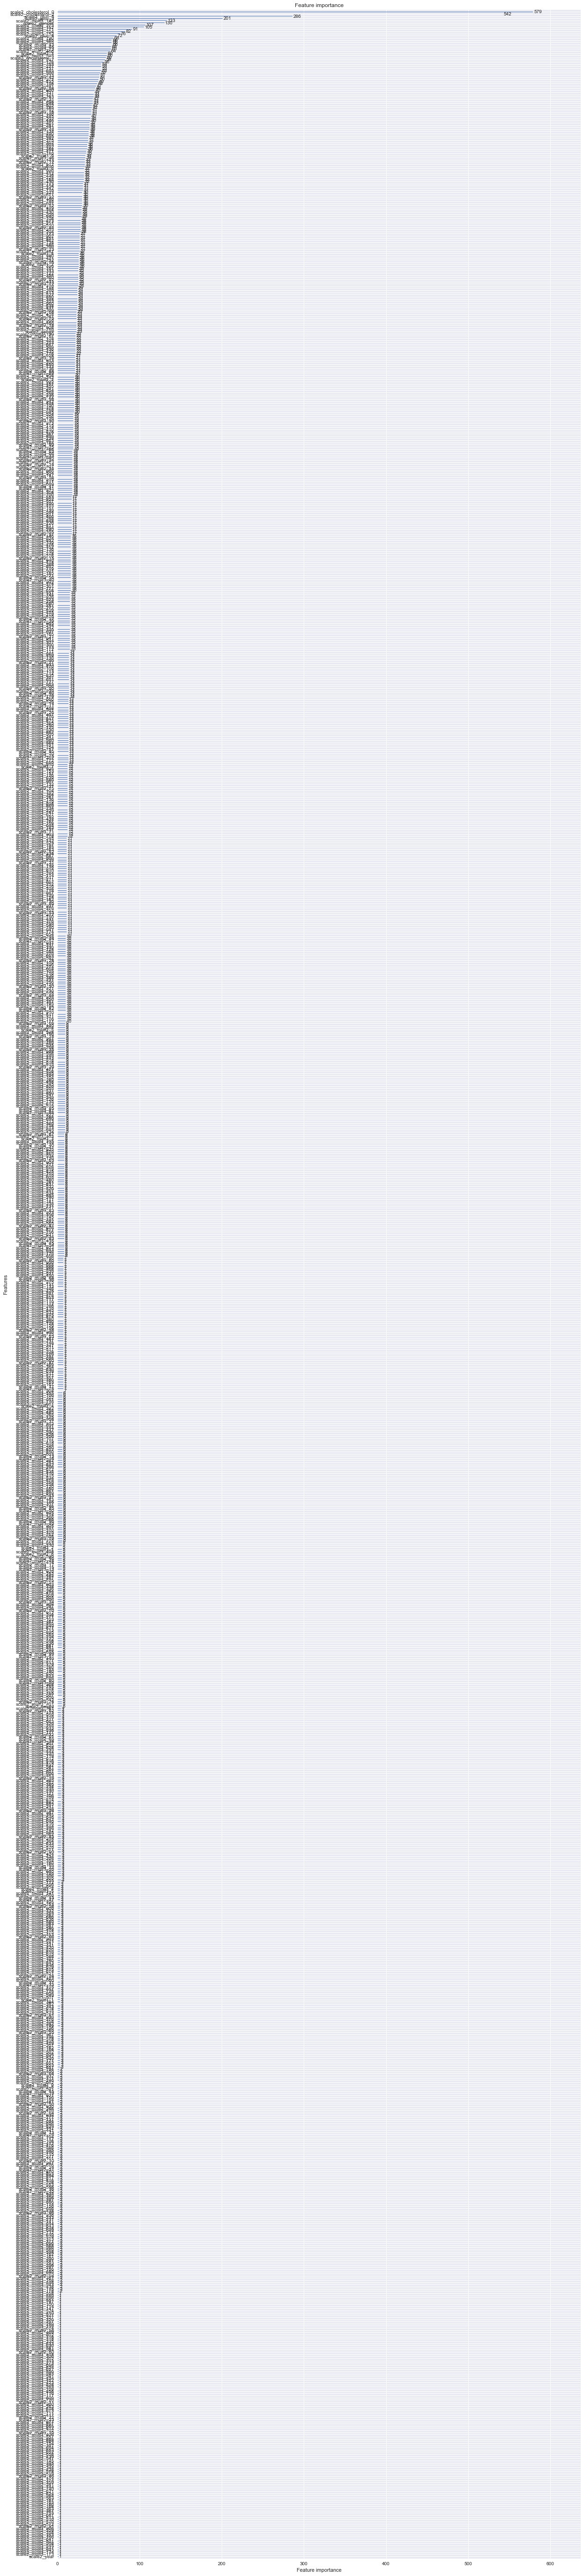

In [83]:
fig, ax = plt.subplots(1,1,figsize=(20,100))
lightgbm.plot_importance(ml.EG.transformer_dict["lgbm_s1"].transformer.booster_, ax = ax)

In [87]:
x = zip(ml.EG.transformer_dict["lgbm_s1"].transformer.booster_.feature_importance(), ml.EG.transformer_dict["lgbm_s1"].transformer.booster_.feature_name())
lgbm_sortedfl = [k[1] for k in sorted(x, key = lambda x : -x[0])]

In [ ]:
ml.remove_step("add2f")
ml.add_step("add2f", additive_featuring(lgbm_sortedfl[0:60], 2, "cardio", lrclf_params_1, "add2f"), prerequisites = ["scale1"])
ml.compute_step("add2f")

In [ ]:
#importance = ml.EG.transformer_dict["xgb_s1"].transformer.booster().get_fscore()
#imp_fl = list(pd.Series(index = importance.keys(), data = importance.values()).sort_values(ascending = False).index)

In [ ]:
#ml.remove_step("add3f")
#ml.add_step("add3f", additive_featuring(imp_fl, 3, "cardio", lrclf_params_1, "add3f"), prerequisites = ["scale1"])
#ml.compute_step("add3f")

In [ ]:
xgb_s2_params = {"objective":"binary:logistic", "max_depth":5, "learning_rate":0.01,
                 "n_estimators": 500, "nthread":8, "base_score":0.5, "seed":47, "missing":None}
ml.remove_step("xgb_s2")
xgb_s2_fl = ml.get_step_columns("scale1") + ml.get_step_columns("add3f") + ml.get_step_columns("lr_s2")
ml.add_step("xgb_s2", xgb_prediction(xgb_s2_fl, "cardio", xgb_s2_params, "xgb_s2"), prerequisites = ["scale1", "add3f", "lr_s2"])

In [ ]:
ml.compute_step("xgb_s2")

In [ ]:
importance2 = ml.EG.transformer_dict["xgb_s2"].transformer.booster().get_fscore()
imp_fl2 = list(pd.Series(index = importance2.keys(), data = importance2.values()).sort_values(ascending = False).index)[0:20]

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
xgboost.plot_importance(ml.EG.transformer_dict["xgb_s1"].transformer, ax = ax)

In [ ]:
std = ml.test[["xgb_s1", "id"]].groupby("id").std()

In [ ]:
ml.test[ml.test.id == 54064]

In [ ]:
measure_logloss(ml, "train", "cardio", "xgb_s1")

In [75]:
ml.test[["lr_s2", "id"]].groupby("id").mean().reset_index().drop("id", axis = 1).to_csv("lr_s2.csv", header = False, index = False)

In [136]:
ml.test[["lgbm_s1", "id"]].groupby("id").mean().reset_index().drop("id", axis = 1).to_csv("lgbm_s1.csv", header = False, index = False)

In [91]:
def get_proba(d):
    d = d.astype(float)
    sum_v = sum(d.values)
    for i in d.keys():
        d[i] *= (1.0 / sum_v)
    return d

def fill_categorical_nans(train, test, features):
    train = train.copy()
    test = test.copy()
    for f in features:
        train_d = get_proba(train[f].value_counts())
        train.loc[train[f].isnull(), f] = np.random.choice(train_d.keys(), size = len(train[train[f].isnull()]), 
                                                           p=train_d.values)
        
        test.loc[test[f].isnull(), f] = np.random.choice(train_d.keys(), size = len(test[test[f].isnull()]), 
                                                           p=train_d.values)
    return train, test
    

In [137]:
ml.test[["lgbm_s1", "id"]].groupby("id").std()

,lgbm_s1
id,
5,NaN
6,0.052710
7,NaN
10,0.038180
11,NaN
17,NaN
19,0.030963
20,NaN
22,NaN


In [138]:
train, test = fill_categorical_nans(train, test, ["smoke", "alco", "active"])

In [139]:
out = pd.merge(test[["id", "smoke", "alco", "active"]], ml.test[["id", "smoke", "alco", "active", "lgbm_s1"]], on = ["id", "smoke", "alco", "active"], how = "inner")

In [140]:
out.drop(["id", "smoke", "alco", "active"], axis = 1).to_csv("lgbm_s1_nan.csv", header = False, index = False)

In [141]:
out.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            29990, 29991, 29992, 29993, 29994, 29995, 29996, 29997, 29998,
            29999],
           dtype='int64', length=30000)

In [143]:
abs((ml.test[["lgbm_s1", "id"]].groupby("id").mean().reset_index().drop("id", axis = 1) - out.drop(["id", "smoke", "alco", "active"], axis = 1))).mean()

lgbm_s1    0.004016
dtype: float64